In [1]:
import os.path
import sys

from keras import callbacks, models
from datahandler.constants import all_features, data_version, acc_features, tensorboard_dir, location_labels
from datahandler.data_preprocessing import get_train_test_data, load_data_v3
from models.log_writer import LogWriter
from models.lstm import make_lstm_model_v1
from transformer import make_transformer_model_v1
from cnn import make_cnn_model_v1, make_cnn_model_v2
import matplotlib.pyplot as plt
from utils import print_line_divider
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns

In [20]:
# LOGGING CONFIGURATION
enabled_log = False
enabled_tensor_board = False
log_writer = LogWriter(enabled_log)

In [21]:
# TRAINING CONFIGURATION
print("STARTING THE TRAINING PROCESS")
window_time_in_seconds = 2
window_size = 40
epochs = 1000
batch_size = 32
validation_split = 1 / 9
optimizer = 'adam'
loss_function = "sparse_categorical_crossentropy"
supported_features = all_features

log_writer.write("Configuration", line_divider=True)
log_writer.write(
    f"""Window size: {window_size}
Window time in second: ${window_time_in_seconds}
Maximum number of epochs: ${epochs}
Batch size: ${batch_size}
Validation split: ${validation_split}
Optimizer: ${optimizer}
Loss function: ${loss_function}
Features used for training: ${str(supported_features)}"""
)

STARTING THE TRAINING PROCESS


In [22]:
# DATA Loader
print_line_divider()
print("Preparing data...")
# x_train, y_train, x_test, y_test = get_train_test_data(supported_features, window_time_in_seconds, window_size)
x_train, y_train, x_test, y_test = load_data_v3(
    features = supported_features,
    window_time_in_seconds = window_time_in_seconds,
    window_size = window_size
)
print("Train data shape: " + str(x_train.shape) + " | Train label shape: " + str(y_train.shape))
print("Test data shape: " + str(x_test.shape) + " | Test label shape: " + str(y_test.shape))
print_line_divider()
log_writer.write("Data", line_divider=True)
log_writer.write("Data loaded from version " + data_version)
log_writer.write(
    f"""Data training shape: ${x_train.shape}
Data testing shape: ${x_test.shape}"""
)

****************************************************
Preparing data...
Train data shape: (7195, 40, 3) | Train label shape: (7195,)
Test data shape: (914, 40, 3) | Test label shape: (914,)
****************************************************


In [26]:
# SETTING UP THE MODEL
input_shape = (window_size, len(supported_features))
# model_name, model = make_cnn_model_v1(input_shape=input_shape)
model_name, model = make_lstm_model_v1(input_shape=input_shape)
# model_name, model = make_transformer_model_v1(
#     input_shape=input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=2,
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )
print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 52,205
Trainable params: 52,205
Non-trainable params: 0
_________________________________________________________________
****************************************************
None


In [27]:
# LOGGING THE MODEL
log_writer.write("Model", line_divider=True)
log_writer.write("Model name: " + model_name)
log_writer.write(short_model_summary)

In [28]:
# MODELS CALLBACK AND SETUP
callback_list = [
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=40, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1)
]
if enabled_tensor_board:
    callback_list.append(callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)

In [29]:
# TRAINING
print_line_divider()
print("Starting to train...")
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))

****************************************************
Starting to train...
Epoch 1/1000
200/200 [==============================] - 4s 16ms/step - loss: 1.0017 - sparse_categorical_accuracy: 0.5479 - val_loss: 1.6240 - val_sparse_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/1000
200/200 [==============================] - 3s 15ms/step - loss: 0.6994 - sparse_categorical_accuracy: 0.6974 - val_loss: 1.1620 - val_sparse_categorical_accuracy: 0.4575 - lr: 0.0010
Epoch 3/1000
200/200 [==============================] - 3s 16ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.7098 - val_loss: 1.9923 - val_sparse_categorical_accuracy: 0.2875 - lr: 0.0010
Epoch 4/1000
200/200 [==============================] - 3s 16ms/step - loss: 0.6185 - sparse_categorical_accuracy: 0.7359 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.5425 - lr: 0.0010
Epoch 5/1000
200/200 [==============================] - 3s 17ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.7282 - val_loss: 1.8081 -

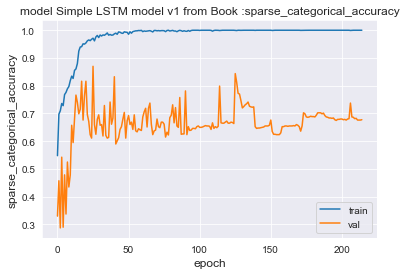

In [30]:
# PLOTTING
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + model_name + " :" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

29/29 [==============================] - 0s 6ms/step - loss: 0.8931 - sparse_categorical_accuracy: 0.8523
****************************************************
Test accuracy 0.8522976040840149
Test loss 0.8930969834327698


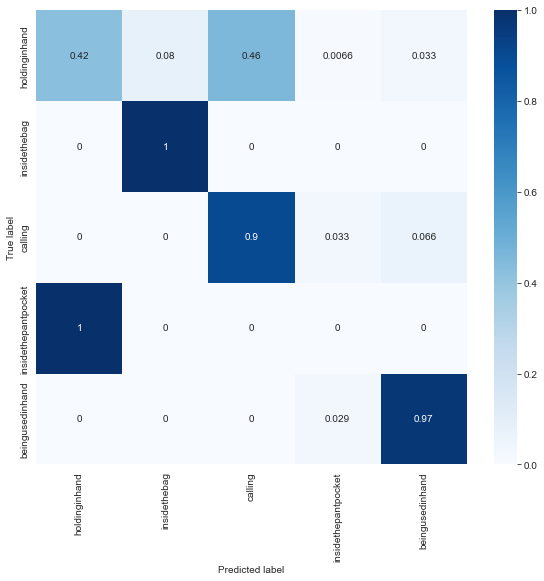

In [31]:
# EVALUATION
model = models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()

log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.close()